<a href="https://colab.research.google.com/github/JerryLiu789/Prediction-of-quality-of-Wine/blob/main/Prediction_of_quality_of_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 環境準備

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('https://raw.githubusercontent.com/aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv')

# Red Wine Quality 資料欄位定義

In [3]:
# fixed acidity：固定酸度
# volatile acidity：揮發性酸度
# citric acid：檸檬酸
# residual sugar：殘糖
# chlorides：氯化物
# free sulfur dioxide：遊離二氧化硫
# total sulfur dioxide：總二氧化硫
# density：密度
# pH：pH值
# sulphates：硫酸鹽
# alcohol：酒精度
# quality：品質(分數介於 0 和 10 之間)

# 確認資料狀況

In [4]:
# 確認資料狀況
print(df.describe())
print('-'*60)
print(df.info())
print('-'*60)
print(df.isnull().sum())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

# 確認資料分佈

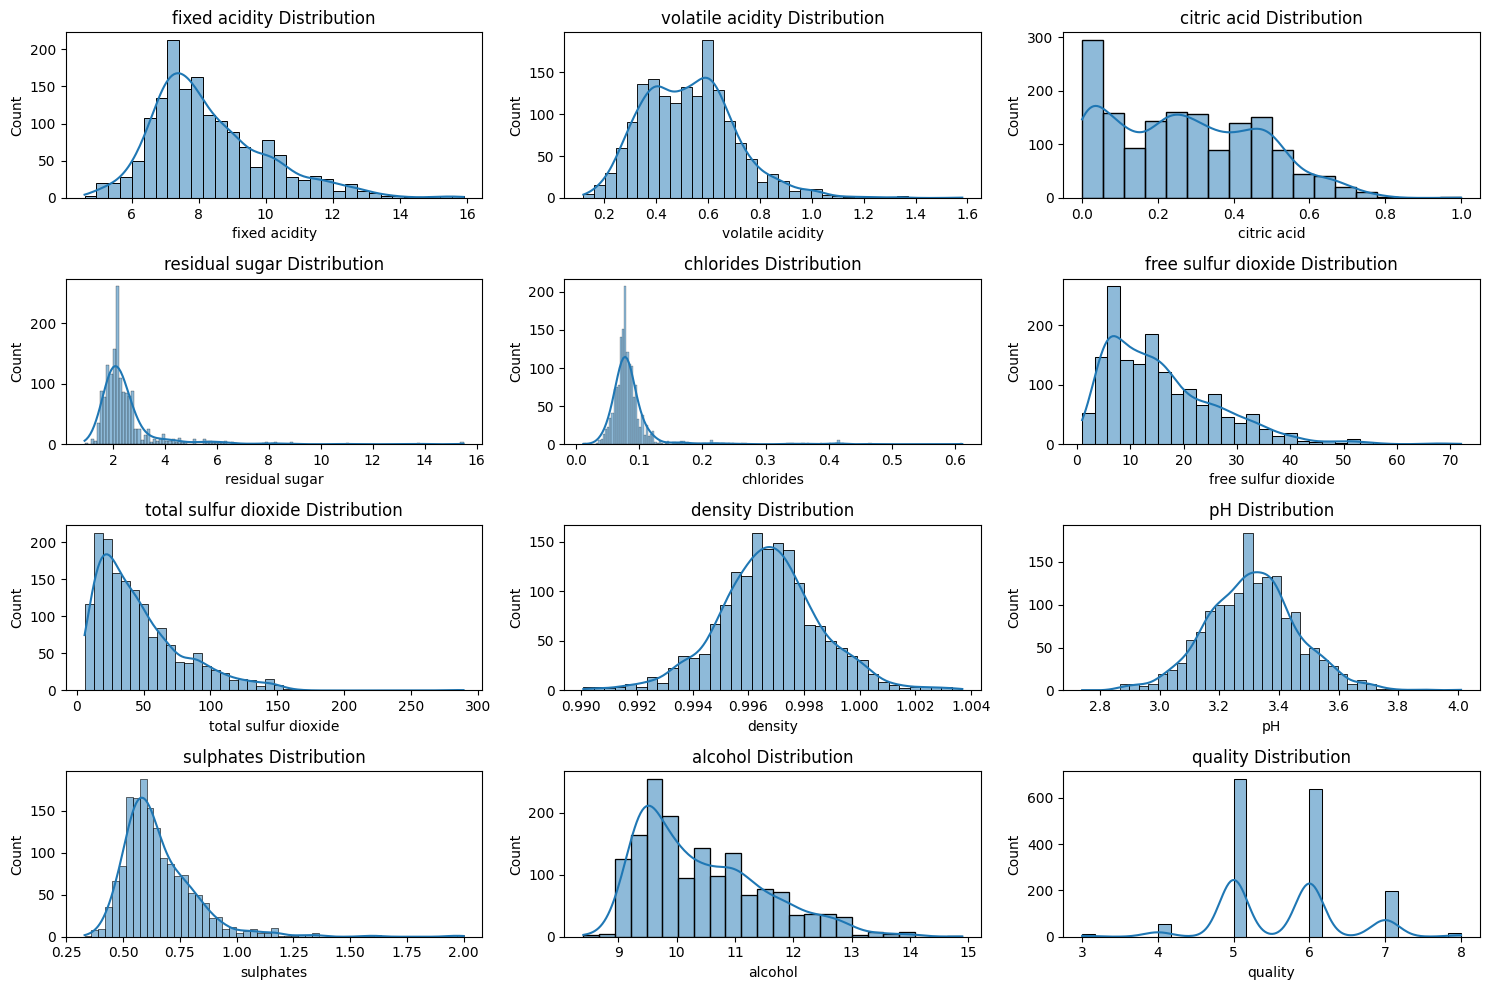

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

# 定義變數名稱
variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
             'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
             'pH', 'sulphates', 'alcohol', 'quality']

# 設置圖形大小
plt.figure(figsize=(15, 10))

# 迴圈繪製每個變數的分佈圖
for i, var in enumerate(variables):
    plt.subplot(4, 3, i+1)  # 4行3列的子圖
    sns.histplot(df[var], kde=True)
    plt.title(f'{var} Distribution')

# 調整佈局
plt.tight_layout()
plt.show()

異常值：部分特徵，如fixed acidity, residual sugar, chlorides, total sulfur dioxide, alcohol等可能存在一些異常值（極端高或低的數值），這些異常值在後續的分析或模型訓練中可能需要特殊處理。

偏態：多個變數如volatile acidity, citric acid, residual sugar顯示出分佈有些偏態的情況，可能需要進行變換或處理來使數據更加正態化。

數據集的特徵：整體來看，大部分數據是合理且分佈正常的，適合用於後續的統計分析和模型訓練。

quality 品質集中度高：數據集中大部分紅酒的品質評分集中在5到6之間，表示大部分紅酒品質屬於中等水平。

quality 數據分佈正常：雖然數據略有偏態，但整體分佈較為正常且均衡，這為後續的分析和模型訓練提供了穩定的基礎。

quality 缺少極端樣本：數據中缺少品質極高或極低的紅酒樣本，這可能影響模型對於極端情況的預測能力。

# 建立第一個 Baseline 版本

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

df_train = df.copy()

X = df_train.drop('quality', axis = 1)
y = df_train['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 5)
print(rfc_eval)
print(rfc_eval.mean())
print(rfc_eval.std())

# 在測試集上進行最終評估
rfc.fit(X_train, y_train)  # 在整個訓練集上訓練模型
test_accuracy = rfc.score(X_test, y_test)
print("Test Accuracy on unseen data:", test_accuracy)

[0.6640625  0.6796875  0.640625   0.703125   0.75294118]
0.6880882352941177
0.03829510487398734
Test Accuracy on unseen data: 0.65625


# 進行關聯分析

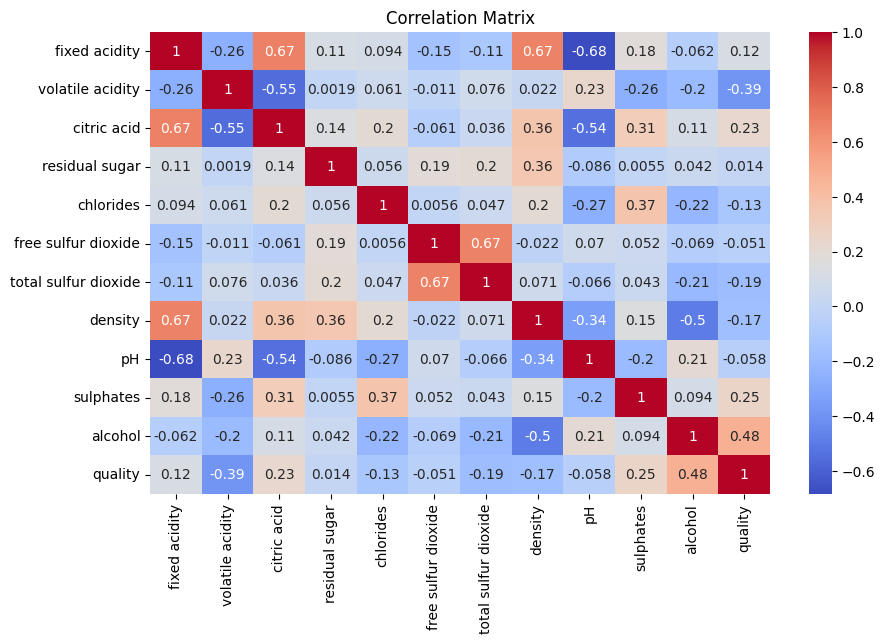

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用皮爾森相關係數來計算相關係數矩陣
correlation_matrix = df.corr()

# 繪製相關係數矩陣熱圖
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

alcohol 和 quality 之間的正相關（0.48）

volatile acidity 和 quality 之間的負相關（-0.39）

sulphates 和 quality 之間的正相關（0.25）

total sulfur dioxide 和 free sulfur dioxide 之間的強正相關（0.67）

density 和 fixed acidity 之間的正相關（0.67）

pH 和 fixed acidity 之間的負相關（-0.68）

# 利用主成分分析(PCA)來降維，處理多重共線性問題與簡化模型

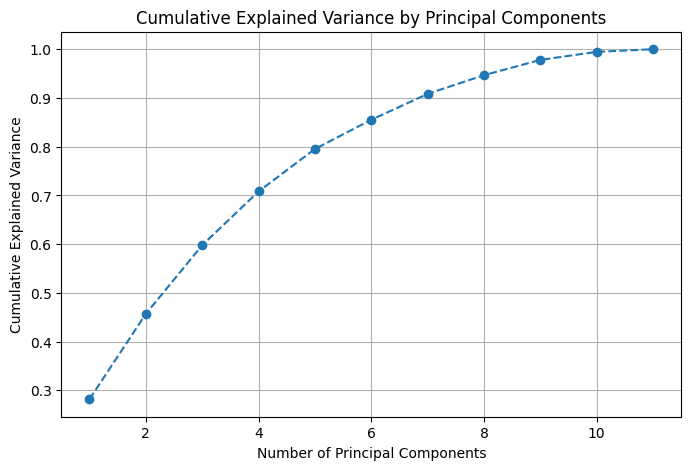

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# 標準化數據
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 應用PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 檢查每個主成分的解釋變異量
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# 繪製解釋變異量圖
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [9]:
# 根據解釋變異量決定保留的主成分數量
n_components = 6 # 選擇前6個主成份，累積解釋變異量約85%
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# 轉換後的數據框架
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# 將PCA變換後的數據與標籤結合
final_data = pd.concat([X_pca_df, y.reset_index(drop=True)], axis=1)

# 訓練隨機森林模型
X_train, X_test, y_train, y_test = train_test_split(X_pca_df, y, test_size = 0.2, random_state = 42)
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 5)
print(rfc_eval)
print(rfc_eval.mean())
print(rfc_eval.std())

# 在測試集上進行最終評估
rfc.fit(X_train, y_train)  # 在整個訓練集上訓練模型
test_accuracy = rfc.score(X_test, y_test)
print("Test Accuracy on unseen data:", test_accuracy)

[0.6328125  0.6640625  0.625      0.703125   0.72941176]
0.6708823529411765
0.040165394905074966
Test Accuracy on unseen data: 0.65


使用PCA後，成效不明顯，嘗試使用其它特徵工程方法來提升預測準確率

# 創建新特徵

In [10]:
# 查看標籤分佈狀況

df['quality'].value_counts()

,count
quality,
5,681
6,638
7,199
4,53
8,18
3,10


In [11]:
# 新建新特徵，quality= 3、4 時 quality_class=0 ,quality= 5、6 時 quality_class=1 ,quality= 7、8 時 quality_class=2 ,

df_train2 = df.copy()

df_train2['quality_class'] = df_train2['quality'].apply(lambda x: 0 if x in [3, 4] else 1 if x in [5, 6] else 2)

X = df_train2.drop('quality', axis = 1)
y = df_train2['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 5)
print(rfc_eval)
print(rfc_eval.mean())
print(rfc_eval.std())

# 在測試集上進行最終評估
rfc.fit(X_train, y_train)  # 在整個訓練集上訓練模型
test_accuracy = rfc.score(X_test, y_test)
print("Test Accuracy on unseen data:", test_accuracy)

[0.8125     0.78515625 0.7890625  0.78125    0.85490196]
0.8045741421568626
0.02741309809532251
Test Accuracy on unseen data: 0.78125


新增的特徵將 Accuracy 由 0.65 提升至 0.78

# 簡化模型

In [15]:
df_train3 = df_train2.copy()

df_train3.drop(columns=['free sulfur dioxide', 'fixed acidity', 'pH'], inplace=True)

X = df_train3.drop('quality', axis = 1)
y = df_train3['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc_eval = cross_val_score(estimator = rfc, X = X_train, y = y_train, cv = 5)
print(rfc_eval)
print(rfc_eval.mean())
print(rfc_eval.std())

# 在測試集上進行最終評估
rfc.fit(X_train, y_train)  # 在整個訓練集上訓練模型
test_accuracy = rfc.score(X_test, y_test)
print("Test Accuracy on unseen data:", test_accuracy)

[0.80078125 0.77734375 0.796875   0.8046875  0.81568627]
0.7990747549019608
0.012549367413656323
Test Accuracy on unseen data: 0.790625


將具有多重貢獻性的特徵移除，準確率提升約1%，標準差減少一半

# 用精確率（Precision）、召回率（Recall）、F1分數來檢查標籤不平衡問題

In [17]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# 在測試集上進行預測
y_pred = rfc.predict(X_test)

# 計算和顯示精確率、召回率、F1分數
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 顯示詳細的分類報告
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Precision: 0.5572
Recall: 0.5864
F1 Score: 0.5710

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.91      1.00      0.95        10
           5       0.76      0.79      0.77       130
           6       0.79      0.75      0.77       132
           7       0.89      0.98      0.93        42
           8       0.00      0.00      0.00         5

    accuracy                           0.79       320
   macro avg       0.56      0.59      0.57       320
weighted avg       0.78      0.79      0.78       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

Precision: 0.5572：模型預測為正類的樣本中，實際為正類的比例是 55.72%。這個數值表明模型在正確識別不同品質類別時有些困難。

Recall: 0.5864：實際為正類的樣本中，被模型正確識別的比例是 58.64%。這意味著模型能夠檢測出大部分的正類，但仍然漏掉了一些。

F1 Score: 0.5710：這是精確率和召回率的調和平均數，反映了模型在處理正確率和檢測率之間的平衡。這個分數表明模型在兩者之間存在一定的妥協，但整體表現中等。


class 3 和 class 8樣本數量極少，導致模型完全無法識別這些類別。表明數據集的標籤不平衡問題影響了模型的預測能力。

class 4, class 7上表現不錯，但在少數類別上表現不佳，意味著需要進一步處理標籤不平衡問題。

# 使用 SMOTE 進行過採樣處理標籤不平衡問題

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import pandas as pd

# 準備特徵和標籤
X = df_train3.drop('quality', axis=1)
y = df_train3['quality']

# 分割數據集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 使用 SMOTE 進行過採樣
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# 創建隨機森林分類器
rfc = RandomForestClassifier(n_estimators=200, random_state=42)

# 1. 交叉驗證
rfc_cv_scores = cross_val_score(estimator=rfc, X=X_train_resampled, y=y_train_resampled, cv=5)
print("Cross-Validation Scores:", rfc_cv_scores)
print("Mean Cross-Validation Score:", rfc_cv_scores.mean())
print("Standard Deviation of Cross-Validation Scores:", rfc_cv_scores.std())

# 在整個過採樣後的訓練集上訓練模型
rfc.fit(X_train_resampled, y_train_resampled)

# 2. 在測試集上進行最終評估
test_accuracy = rfc.score(X_test, y_test)
print(f"\nTest Accuracy on unseen data: {test_accuracy:.4f}")

# 3. 在測試集上進行預測
y_pred = rfc.predict(X_test)

# 3, 4, 5. 計算精確率（Precision）、召回率（Recall）和 F1分數
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 顯示詳細的分類報告
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Cross-Validation Scores: [0.92749245 0.91679274 0.93192133 0.93192133 0.93494705]
Mean Cross-Validation Score: 0.9286149795923965
Standard Deviation of Cross-Validation Scores: 0.006371569775491351

Test Accuracy on unseen data: 0.7906
Precision: 0.6156
Recall: 0.6157
F1 Score: 0.6124

Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.91      1.00      0.95        10
           5       0.77      0.78      0.77       130
           6       0.78      0.77      0.77       132
           7       0.91      0.95      0.93        42
           8       0.33      0.20      0.25         5

    accuracy                           0.79       320
   macro avg       0.62      0.62      0.61       320
weighted avg       0.78      0.79      0.79       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:14

交叉驗證的評分從0.79提升到0.92，但在測試集的預測成績維持0.79，明顯有過擬合的狀況

精確率（Precision）、召回率（Recall）、F1分數略有提升

# 優化參數

In [18]:
# from sklearn.model_selection import GridSearchCV, train_test_split

# # 假設你的 DataFrame 是 df
# X = df_train.drop(columns=['quality'])
# y = df_train['quality']

# # 分割數據集為訓練集和測試集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 分割數據集為訓練集和測試集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # 創建隨機森林模型
# rfc = RandomForestClassifier(random_state=42)

# # 使用 GridSearchCV 進行網格搜索
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # 提取最佳模型
# best_model = grid_search.best_estimator_

# # 使用交叉驗證驗證結果
# cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')

# # 輸出交叉驗證的結果
# print("Cross-validation scores:", cv_scores)
# print("Mean cross-validation score:", cv_scores.mean())
# print("Standard deviation of cross-validation scores:", cv_scores.std())

# # 最佳模型在測試集上的最終評估
# test_accuracy = best_model.score(X_test, y_test)
# print("Test Accuracy:", test_accuracy)
